In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from src.plots import (
    plot_distribution,
    draw_plots_grid,
    plot_bivariate_distribution
)
from src.calculations_and_feature_engineering import (
    calculate_rolling_baselines, 
    add_risk_scores,
    engineer_target_variable
)

    

In [2]:
df = pd.read_csv("./cleaned_data/14thJune2025_p07.csv", )
df.set_index("dateTime", inplace = True)
df.drop("participant_id", axis = 1, inplace = True)

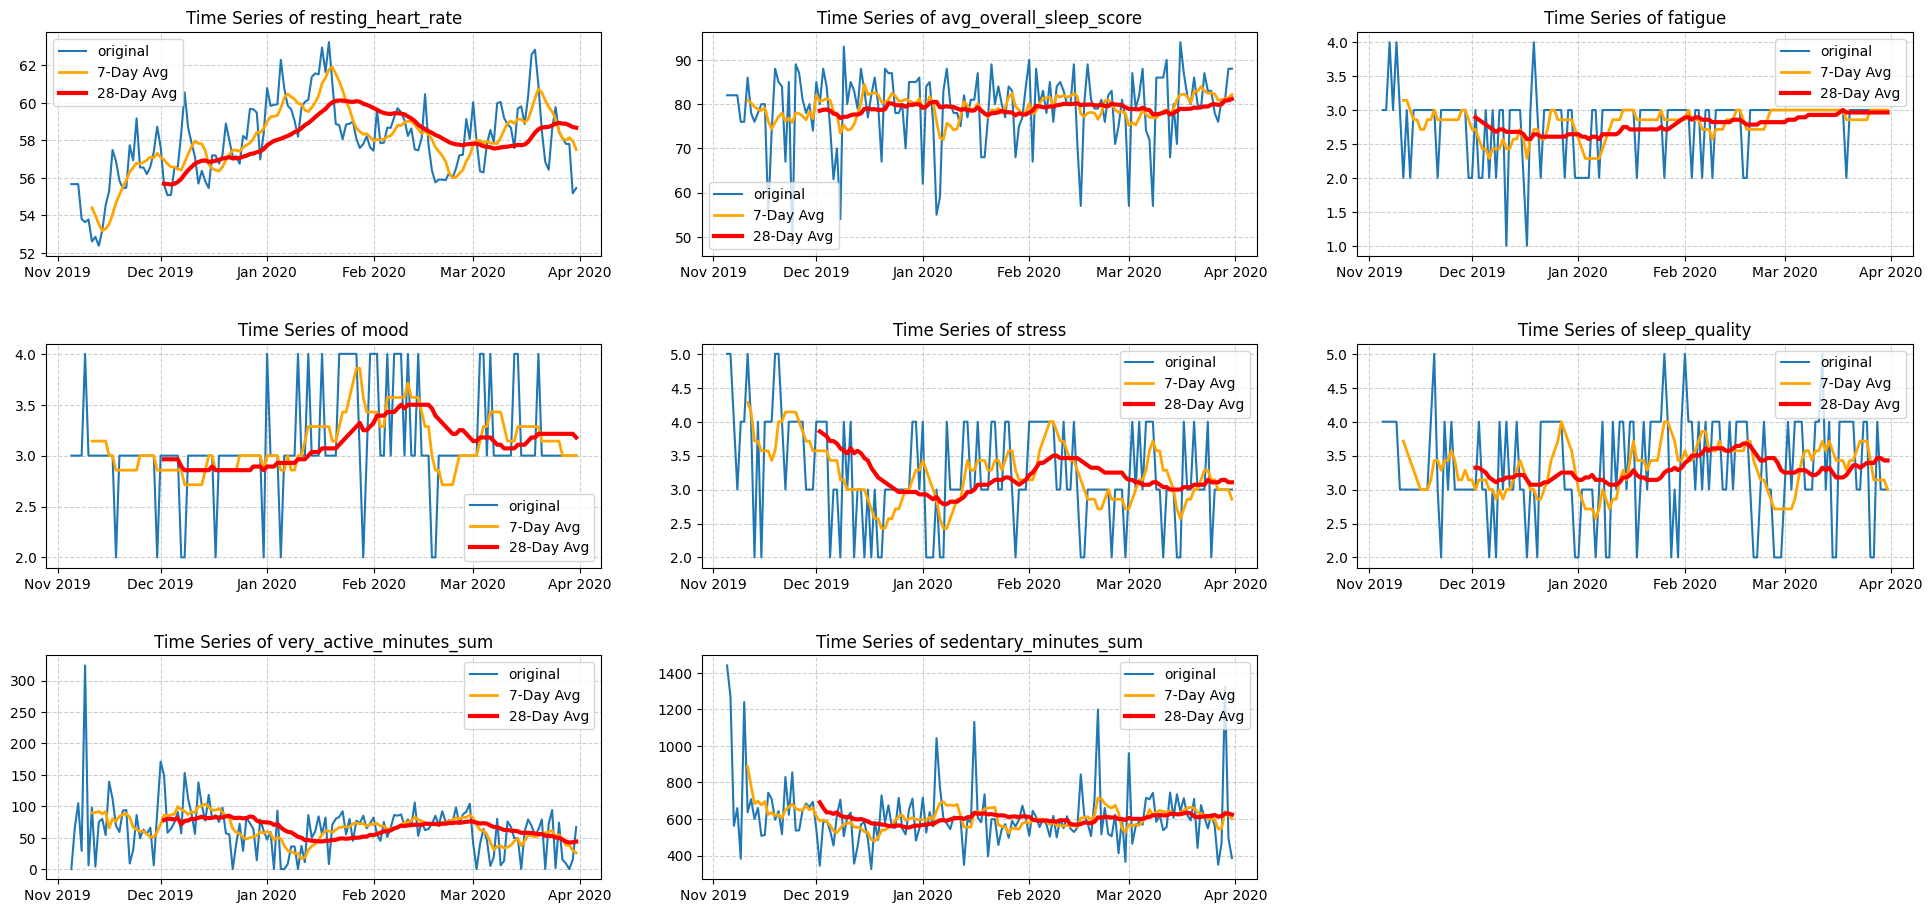

In [3]:
draw_plots_grid(df, df.columns, nrows = 5, ncols = 3)

Calculate Rolling Baselines: For each student, we need to calculate their personal 30-day rolling baseline (mean and standard deviation) for the physiological metrics.

Calculate rhr_30d_mean and rhr_30d_std for resting_heart_rate.
Calculate sleep_score_30d_mean and sleep_score_30d_std for avg_overall_sleep_score.
Calculate Daily Sub-Scores: Using the baselines, we'll compute the two components of the risk score for each day.

Subjective_Distress_Score (0-4 points): Sum points for negative self-reports (fatigue, mood, stress, sleep_quality scores of 1 or 2).
Physiological_Deviation_Score (0-2 points):
+1 point if resting_heart_rate is more than one standard deviation above its 30-day mean.
+1 point if avg_overall_sleep_score is more than one standard deviation below its 30-day mean.
Calculate Composite Risk Score:

Create a Composite_Risk_Score column by summing the two scores above.
Identify High-Risk State:

Create a binary High_Risk_State column, flagging any day where Composite_Risk_Score >= 3 as 1 and all others as 0.
Engineer the Final Target (Is_High_Risk_Next_7_Days):

This is the final step. For each day, we will look forward into the next 7 days. If a High_Risk_State (1) occurs at any point within that window, we will set Is_High_Risk_Next_7_Days to 1 for the current day. Otherwise, it will be 0.

In [4]:
df

,resting_heart_rate,avg_overall_sleep_score,fatigue,mood,stress,sleep_quality,very_active_minutes_sum,sedentary_minutes_sum
dateTime,,,,,,,,
2019-11-05,55.667916,82.0,3.0,3.0,5.0,4.0,0,1440
2019-11-06,55.667916,82.0,3.0,3.0,5.0,4.0,65,1270
2019-11-07,55.667916,82.0,4.0,3.0,4.0,4.0,105,563
2019-11-08,53.800657,82.0,3.0,3.0,3.0,4.0,29,660
2019-11-09,53.646626,76.0,4.0,4.0,4.0,4.0,324,383
...,...,...,...,...,...,...,...,...
2020-03-27,58.138510,76.0,3.0,3.0,3.0,2.0,15,350
2020-03-28,57.808391,81.0,3.0,3.0,3.0,4.0,9,467
2020-03-29,57.808391,81.0,3.0,3.0,3.0,3.0,0,1325


In [5]:
df = calculate_rolling_baselines(df, ["resting_heart_rate","avg_overall_sleep_score"], window_size=14, calculate_mean=True, calculate_std=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 148 entries, 2019-11-05 to 2020-03-31
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   resting_heart_rate               148 non-null    float64
 1   avg_overall_sleep_score          148 non-null    float64
 2   fatigue                          148 non-null    float64
 3   mood                             148 non-null    float64
 4   stress                           148 non-null    float64
 5   sleep_quality                    148 non-null    float64
 6   very_active_minutes_sum          148 non-null    int64  
 7   sedentary_minutes_sum            148 non-null    int64  
 8   resting_heart_rate_14_mean       148 non-null    float64
 9   resting_heart_rate_14_std        148 non-null    float64
 10  avg_overall_sleep_score_14_mean  148 non-null    float64
 11  avg_overall_sleep_score_14_std   148 non-null    float64
dtypes: 

In [7]:
df.columns

Index(['resting_heart_rate', 'avg_overall_sleep_score', 'fatigue', 'mood',
       'stress', 'sleep_quality', 'very_active_minutes_sum',
       'sedentary_minutes_sum', 'resting_heart_rate_14_mean',
       'resting_heart_rate_14_std', 'avg_overall_sleep_score_14_mean',
       'avg_overall_sleep_score_14_std'],
      dtype='object')

In [8]:
SUBJECTIVE_COLS = ['fatigue', 'mood', 'stress', 'sleep_quality']

PHYSIOLOGICAL_CONFIG = [
    {
        'metric': 'resting_heart_rate',
        'mean': 'resting_heart_rate_14_mean',
        'std': 'resting_heart_rate_14_std',
        'direction': 'above'
    },
    {
        'metric': 'avg_overall_sleep_score',
        'mean': 'avg_overall_sleep_score_14_mean',
        'std': 'avg_overall_sleep_score_14_std',
        'direction': 'below'
    }
]

In [9]:
df = add_risk_scores(df, 
                subjective_cols_config = SUBJECTIVE_COLS,
                physiological_cols_config=PHYSIOLOGICAL_CONFIG)

Successfully calculated and appended daily risk scores using refactored functions.


In [10]:
RISK_THRESHOLD = 3
LOOKAHEAD_DAYS = 7
df = engineer_target_variable(df, risk_threshold=RISK_THRESHOLD, lookahead_window=LOOKAHEAD_DAYS)


In [11]:
df.columns

Index(['resting_heart_rate', 'avg_overall_sleep_score', 'fatigue', 'mood',
       'stress', 'sleep_quality', 'very_active_minutes_sum',
       'sedentary_minutes_sum', 'resting_heart_rate_14_mean',
       'resting_heart_rate_14_std', 'avg_overall_sleep_score_14_mean',
       'avg_overall_sleep_score_14_std', 'Subjective_Distress_Score',
       'Physiological_Deviation_Score', 'Composite_Risk_Score',
       'High_Risk_State', 'Is_High_Risk_Next_7_Days'],
      dtype='object')

In [12]:
X_columns = [
    'resting_heart_rate',
    'avg_overall_sleep_score',
    'fatigue',
    'mood',
    'stress',
    'sleep_quality',
    'very_active_minutes_sum',
    'sedentary_minutes_sum',
    'resting_heart_rate_14_mean',
    'resting_heart_rate_14_std',
    'avg_overall_sleep_score_14_mean',
    'avg_overall_sleep_score_14_std',
]

y_column = 'Is_High_Risk_Next_7_Days'

<bound method Axes.bar of <Axes: >>

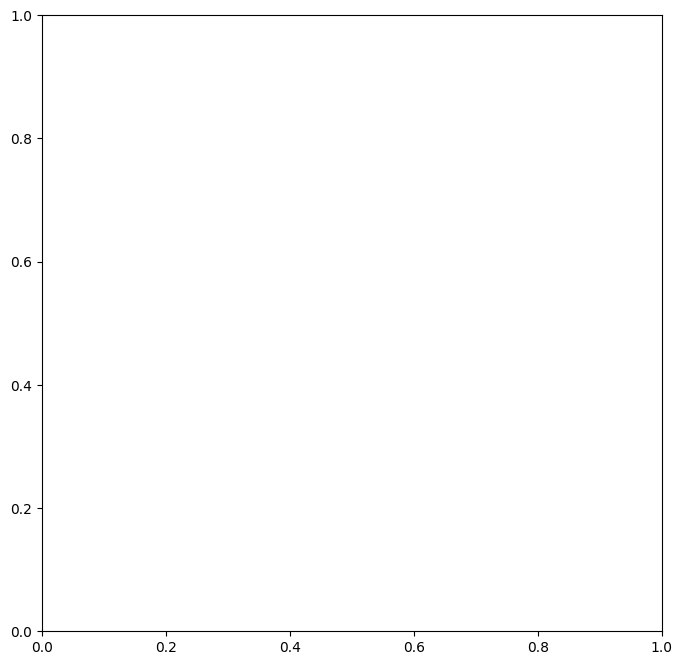

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.bar


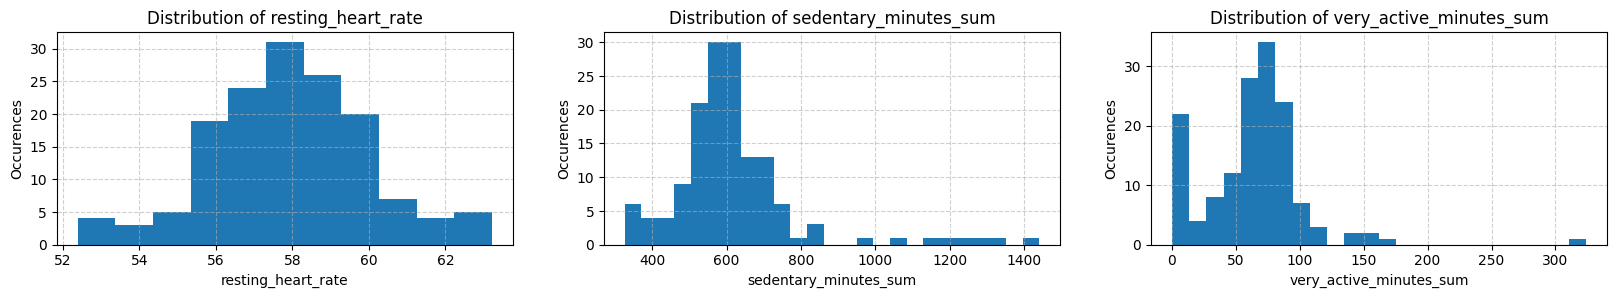

In [14]:
plot_distribution(df, ["resting_heart_rate","sedentary_minutes_sum","very_active_minutes_sum"],type = "hist",nrows=5, ncols=3)

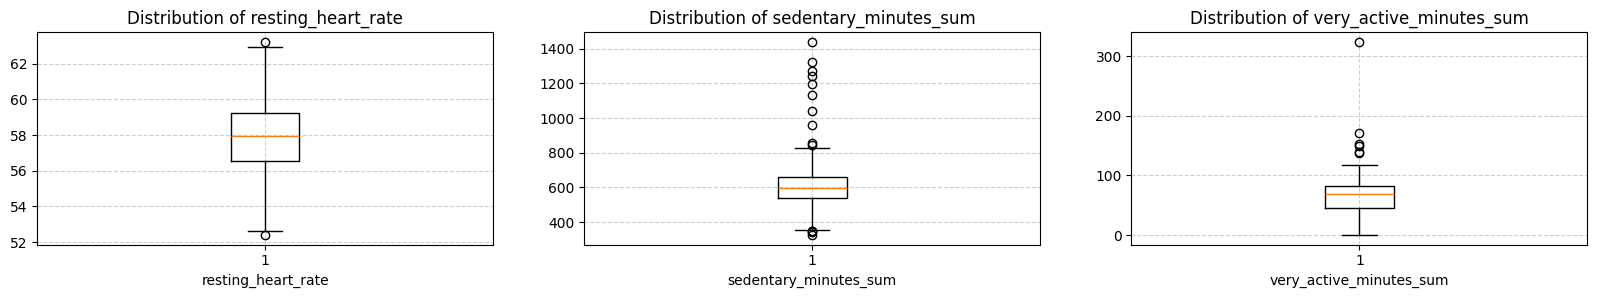

In [15]:
plot_distribution(df, ["resting_heart_rate","sedentary_minutes_sum","very_active_minutes_sum"],type = "box",nrows=5, ncols=3)

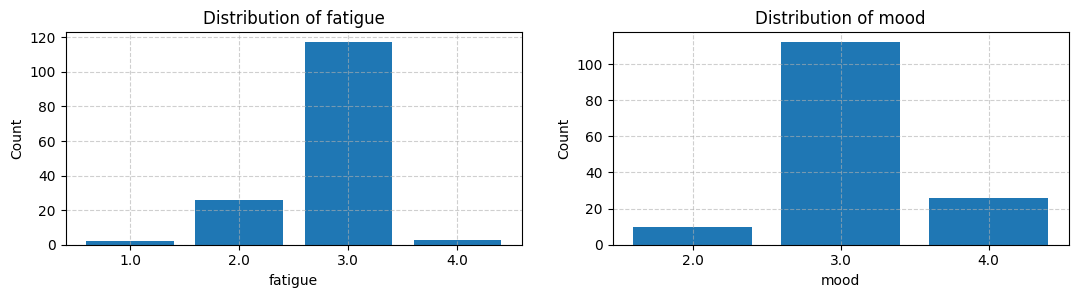

In [16]:
plot_distribution(df, ["fatigue","mood"],type = "bar",nrows=5, ncols=3)

In [17]:
plot_bivariate_distribution(df, columns = ["resting_heart_rate","sedentary_minutes_sum","very_active_minutes_sum"], target = y_column, type = "box",nrows = 2, ncols = 2)

NameError: name 'plot_bivariate_distribution' is not defined

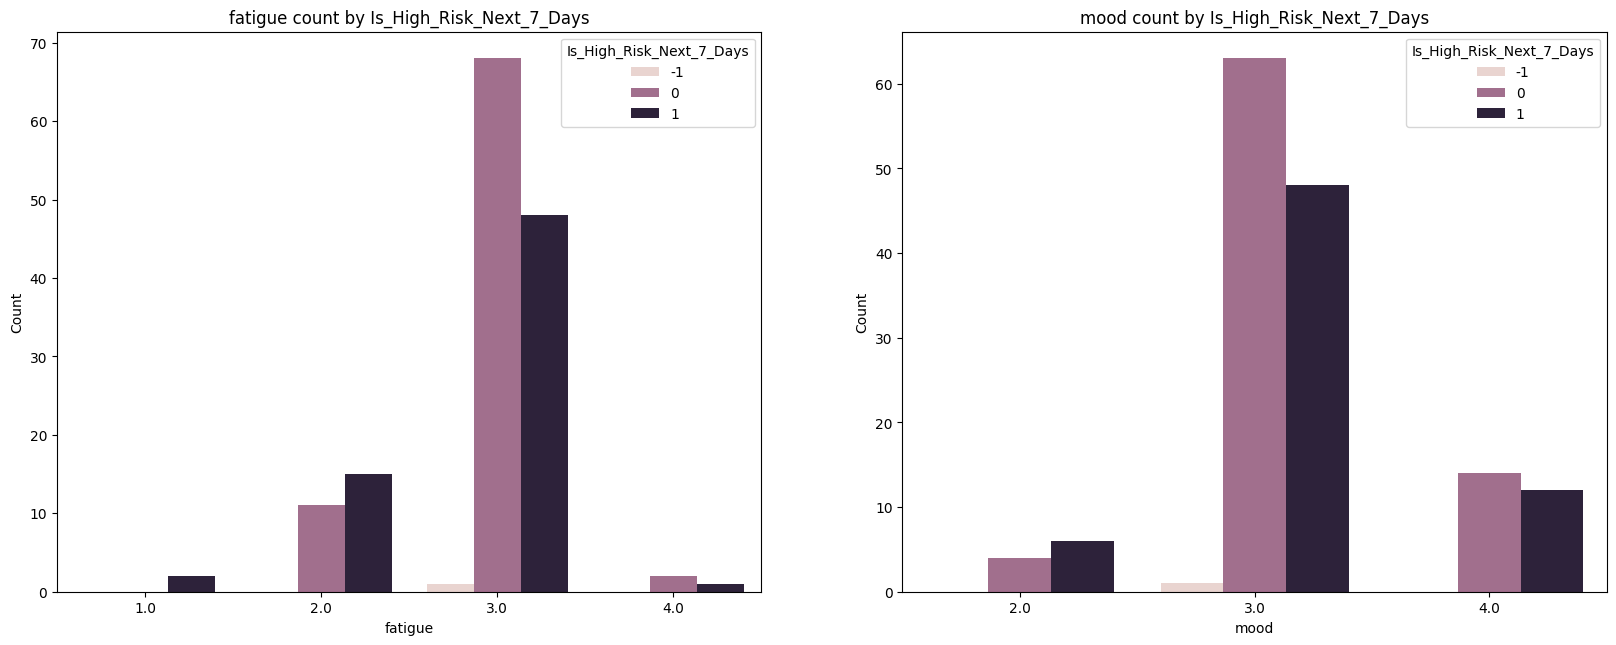

In [ ]:
plot_bivariate_distribution(df, ["fatigue", "mood"], target="Is_High_Risk_Next_7_Days", type="bar")
